## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

## Getting Data for repo (Note: downloading 20k rct data to find the best preforming model)



In [2]:
##Getting Train data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
##Getting validation data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
## Getting test data for rct 20k
! wget https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt

--2022-07-24 09:18:51--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28908792 (28M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]  27.57M  --.-KB/s    in 0.07s   

2022-07-24 09:18:53 (389 MB/s) - ‘train.txt’ saved [28908792/28908792]

--2022-07-24 09:18:54--  https://raw.githubusercontent.com/average-joe25/scientific-abstract-classifier/main/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

In [3]:
## moving them to new folder
! mkdir rct20k
! mv dev.txt rct20k/
! mv train.txt rct20k/
! mv test.txt rct20k/

## EDA and visualization of Data

In [4]:
##Getting lines from the files
def get_data(dataset_type,rct_type):
  parent_folder='/content/'
  with open(str(parent_folder+rct_type+"/"+dataset_type),'r') as f:
    list_lines= f.readlines()
    return list_lines

In [5]:
train_lines_20k=get_data("train.txt","rct20k")
test_lines_20k=get_data("test.txt","rct20k")
val_lines_20k=get_data("dev.txt","rct20k")

In [6]:
len(train_lines_20k),len(test_lines_20k),len(val_lines_20k)

(210040, 35135, 35212)

In [7]:
## function to create dataframe from lines
def convert_to_df(lines):
  abstract_size=0
  dict_list=[]
  abstract=[]
  list_abstract=[]
  for line in lines:
    if(line.startswith("###")):
      if(len(abstract)!=0):
        list_abstract.append(abstract)
      abstract=[]
    else:
      abstract.append(line)
  list_abstract.append(abstract)
  for new_abstract in list_abstract:
    count=0
    for line in new_abstract:
      count+=1
      splitted=line.split('\t')
      if(splitted[0]=='\n'):
        continue
      category=splitted[0]
      text=splitted[1]
      dict_list.append({'target':category,'text':text,'location':float(count/len(new_abstract))})
  list_df=pd.DataFrame(dict_list)
  return list_df


In [8]:
##convert lines to dataframe
train_df=convert_to_df(train_lines_20k)
val_df=convert_to_df(val_lines_20k)
test_df=convert_to_df(test_lines_20k)

In [9]:
train_df.head(15)

,target,text,location
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0.076923
1,METHODS,A total of @ patients with primary knee OA wer...,0.153846
2,METHODS,Outcome measures included pain reduction and i...,0.230769
3,METHODS,Pain was assessed using the visual analog pain...,0.307692
4,METHODS,Secondary outcome measures included the Wester...,0.384615
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",0.461538
6,RESULTS,There was a clinically relevant reduction in t...,0.538462
7,RESULTS,The mean difference between treatment arms ( @...,0.615385
8,RESULTS,"Further , there was a clinically relevant redu...",0.692308
9,RESULTS,These differences remained significant at @ we...,0.769231


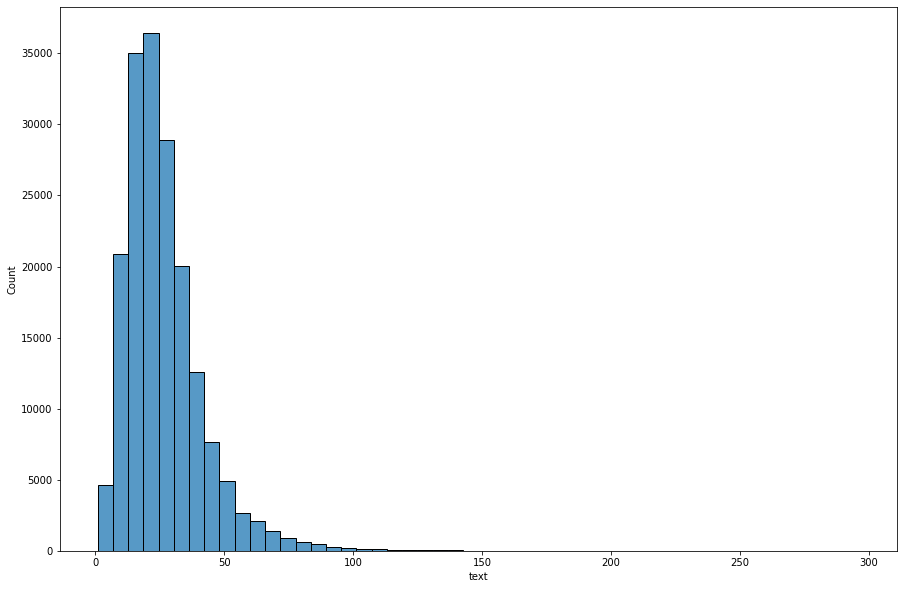

In [10]:
#length line in a abstract
plt.figure(figsize=(15,10))
sns.histplot(x=train_df['text'].apply(lambda x: len(x.split(' '))),bins=50)

In [11]:
## Shortening all sentence to max length of 50
def shorten(text):
  lists=text.split(" ")
  size=np.minimum(50,len(lists))
  t = " ".join(lists[:size])
  return t
train_df['text']=train_df['text'].apply(shorten)
test_df['text']=test_df['text'].apply(shorten)
val_df['text']=val_df['text'].apply(shorten)

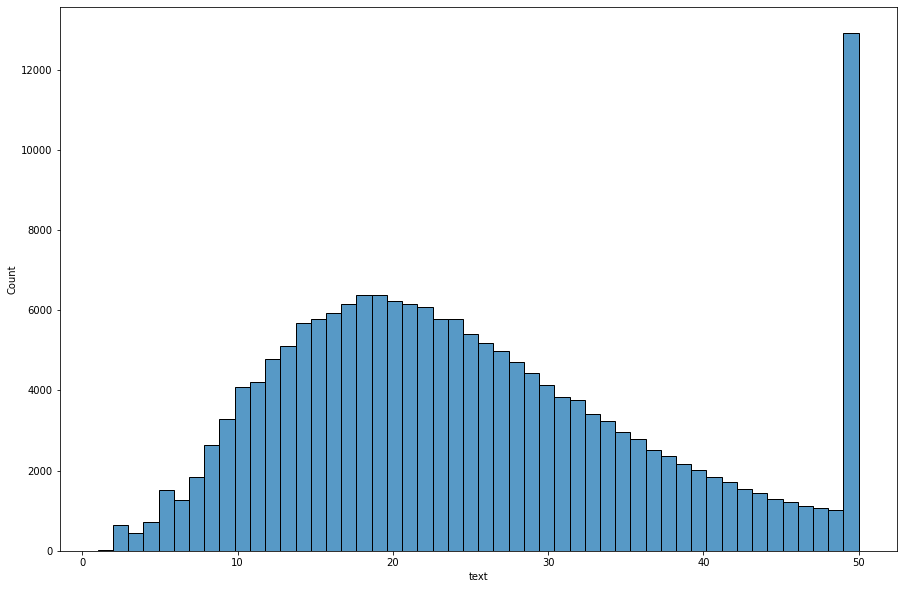

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(x=train_df['text'].apply(lambda x: len(x.split(' '))),bins=50)

In [13]:
## one hot Encoding The  classes
num_classes=train_df['target'].nunique()
class_names=list(train_df['target'].unique())
train_df['target']=train_df['target'].apply(lambda x: class_names.index(x))
def onehotencoding(data,classes):
  return tf.one_hot(data,classes)
train_labels=onehotencoding(train_df['target'],num_classes)

In [14]:
class_names

['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND']

In [15]:
test_df['target']=test_df['target'].apply(lambda x: class_names.index(x))
val_df['target']=val_df['target'].apply(lambda x: class_names.index(x))
test_labels=onehotencoding(test_df['target'],num_classes)
val_labels=onehotencoding(val_df['target'],num_classes)

## Turning DataFrame to tf.data.dataset for faster computing 

In [16]:
from tensorflow.data import Dataset

In [17]:
train_labels_dataset=Dataset.from_tensor_slices(train_labels)
val_labels_dataset=Dataset.from_tensor_slices(val_labels)
test_labels_dataset=Dataset.from_tensor_slices(test_labels)

In [18]:
train_df.head()

,target,text,location
0,0,To investigate the efficacy of @ weeks of dail...,0.076923
1,1,A total of @ patients with primary knee OA wer...,0.153846
2,1,Outcome measures included pain reduction and i...,0.230769
3,1,Pain was assessed using the visual analog pain...,0.307692
4,1,Secondary outcome measures included the Wester...,0.384615


In [19]:
train_dataset=Dataset.zip((Dataset.from_tensor_slices((train_df['text'].to_numpy(),train_df['location'].to_numpy())),train_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=Dataset.zip((Dataset.from_tensor_slices((val_df['text'].to_numpy(),val_df['location'].to_numpy())),val_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=Dataset.zip((Dataset.from_tensor_slices((test_df['text'].to_numpy(),test_df['location'].to_numpy())),test_labels_dataset)).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Modelling using LSTM

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [22]:
#text vectorizor layer
import os
import re
import shutil
import string
import tensorflow as tf

  
text_vec=layers.TextVectorization(max_tokens=5000,output_sequence_length=50,name="text_vectorization")
text_vec.adapt(train_df['text'])

In [23]:
# Creating Text Embedding
text_embed=layers.Embedding(len(text_vec.get_vocabulary()),128,mask_zero=True,name="text_embedding")

In [24]:
## text Modelling
text_Input = layers.Input(shape=(1,),dtype=tf.string,name="text_Input")
x = text_vec(text_Input)
x = text_embed(x)
text_output = layers.Bidirectional(layers.LSTM(32),name="text_LSTM")(x)

In [25]:
## location Modelling 
loc_Input = layers.Input(shape=(1,),name="Location_Input")
k = layers.Dense(10,activation='relu')(loc_Input)
k = layers.Dense(10,activation='relu')(k)
loc_output = layers.Dense(num_classes,activation='relu',name='Location_Output')(k)
loc_model = tf.keras.Model(inputs=loc_Input,outputs=loc_output)

In [26]:
## Main Model
z=layers.Dense(128,activation='relu')(text_output)
z=layers.Dense(64,activation='relu')(z)
z=layers.Dropout(0.5)(z)
z=layers.concatenate((z,loc_model.output))
Output=layers.Dense(num_classes,activation='softmax')(z)

In [27]:
Model4 = tf.keras.Model((text_Input,loc_model.input),Output)
Model4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=Adam(),metrics=['accuracy'])
Model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['text_Input[0][0]']             
 ization)                                                                                         
                                                                                                  
 text_embedding (Embedding)     (None, 50, 128)      640000      ['text_vectorization[0][0]']     
                                                                                                  
 text_LSTM (Bidirectional)      (None, 64)           41216       ['text_embedding[0][0]']   

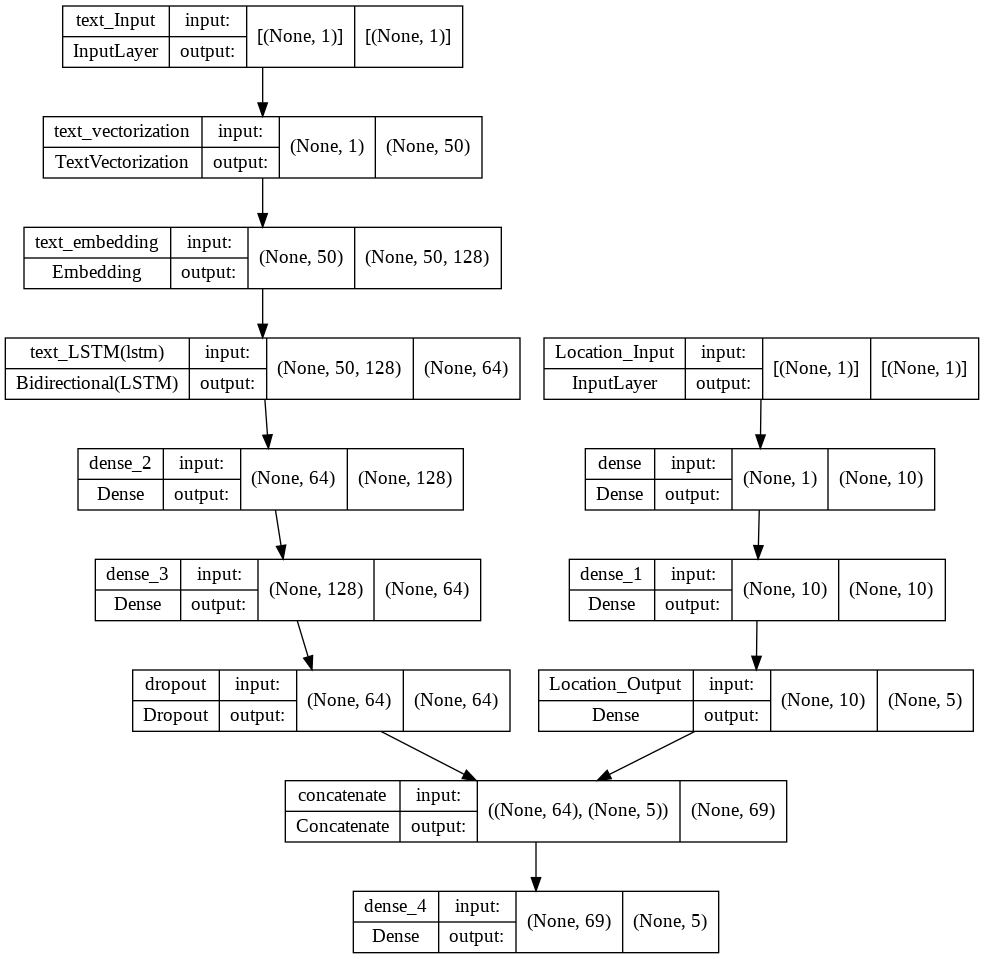

In [28]:
## Model Visualization
from tensorflow.keras.utils import plot_model
plot_model(Model4,show_shapes=True)

In [29]:
batch_train_10precent=int(len(train_dataset)*0.01)
batch_val_10precent=int(len(val_dataset)*0.1)

In [30]:
earlystop=EarlyStopping(monitor='val_accuracy',patience=2,mode='max',verbose=0,restore_best_weights=True)

In [31]:
history= Model4.fit(train_dataset,
                    #steps_per_epoch=batch_train_10precent,
                    epochs=10,
                    validation_data=val_dataset,
                    validation_steps=batch_val_10precent,
                    callbacks=[earlystop])

Epoch 1/10
5627/5627 [==============================] - 108s 17ms/step - loss: 0.4648 - accuracy: 0.8313 - val_loss: 0.3709 - val_accuracy: 0.8574
Epoch 2/10
5627/5627 [==============================] - 91s 16ms/step - loss: 0.3439 - accuracy: 0.8774 - val_loss: 0.3672 - val_accuracy: 0.8600
Epoch 3/10
5627/5627 [==============================] - 88s 16ms/step - loss: 0.2969 - accuracy: 0.8944 - val_loss: 0.3649 - val_accuracy: 0.8664
Epoch 4/10
5627/5627 [==============================] - 88s 16ms/step - loss: 0.2567 - accuracy: 0.9084 - val_loss: 0.3944 - val_accuracy: 0.8590
Epoch 5/10
5627/5627 [==============================] - 88s 16ms/step - loss: 0.2232 - accuracy: 0.9205 - val_loss: 0.4310 - val_accuracy: 0.8604


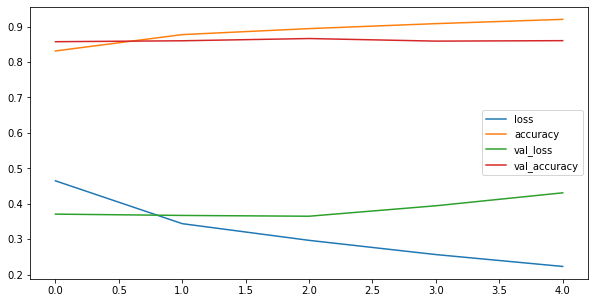

In [32]:
# plotting result
plt.figure(figsize=(10,5))
history=pd.DataFrame(history.history)
plt.plot(history)
plt.legend(history.columns)

## Downloading model


In [33]:
import tensorflow as tf
path = '/content/pubmed_model'
Model4.save(path)


INFO:tensorflow:Assets written to: /content/pubmed_model/assets


INFO:tensorflow:Assets written to: /content/pubmed_model/assets


In [34]:
!zip -r /content/pubmed_model.zip  /content/pubmed_model


  adding: content/pubmed_model/ (stored 0%)
  adding: content/pubmed_model/variables/ (stored 0%)
  adding: content/pubmed_model/variables/variables.index (deflated 69%)
  adding: content/pubmed_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/pubmed_model/assets/ (stored 0%)
  adding: content/pubmed_model/keras_metadata.pb (deflated 91%)
  adding: content/pubmed_model/saved_model.pb (deflated 90%)


## Evaluation

In [ ]:
Model_new=tf.keras.models.load_model("/content/pubmed_model")

In [ ]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
def measure(pred,value):
  eva_dict={'accuracy':accuracy_score(value,pred),'precision':precision_score(value,pred,average='weighted'),'recall':recall_score(value,pred,average='weighted'),'f1_score':f1_score(value,pred,average='weighted')}
  print(eva_dict)

In [ ]:
Model_new.evaluate(val_dataset)

945/945 [==============================] - 9s 7ms/step - loss: 0.3597 - accuracy: 0.8604


[0.3597184717655182, 0.8604196906089783]

In [ ]:
test_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:

print(dummy)

tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], shape=(30135, 5), dtype=float32)


In [ ]:
dummy=tf.data.Dataset.from_tensor_slices(dummy)

In [ ]:

new_dataset=Dataset.zip((tf.data.Dataset.from_tensor_slices((test_df['text'].to_numpy(),test_df['char_text'].to_numpy(),test_df['location'].to_numpy())),dummy)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
pred=Model_new.predict(new_dataset)

In [ ]:
pred=tf.argmax(pred,axis=1)

In [ ]:
measure(pred,test_df['target'])

{'accuracy': 0.7824124771859964, 'precision': 0.7821402014912253, 'recall': 0.7824124771859964, 'f1_score': 0.780138934515068}


In [ ]:
test_lines_20k

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE